## Petróleo WTI values dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

In [2]:
df_petroleo = pd.read_csv('../data/raw/Petroleo WTI.csv')
df_petroleo['Instrument Name'] = 'Petroleo'
df_petroleo.head(10)

,Fecha,Último,Apertura,Máximo,Mínimo,Vol.,% var.,Instrument Name
0,23.05.2022,110.75,110.29,111.89,109.17,-,0.40%,Petroleo
1,22.05.2022,110.31,110.56,110.56,109.53,-,-2.58%,Petroleo
2,20.05.2022,113.23,111.45,114.04,110.85,"20,00K",0.91%,Petroleo
3,19.05.2022,112.21,109.09,112.62,105.13,"68,51K",2.39%,Petroleo
4,18.05.2022,109.59,113.66,115.42,108.46,"103,67K",-2.50%,Petroleo
5,17.05.2022,112.40,113.87,115.56,111.75,"252,63K",-1.58%,Petroleo
6,16.05.2022,114.20,110.98,114.90,108.11,"289,13K",3.36%,Petroleo
7,13.05.2022,110.49,106.65,110.64,106.29,"240,99K",4.11%,Petroleo
8,12.05.2022,106.13,105.63,107.37,102.66,"323,55K",0.40%,Petroleo
9,11.05.2022,105.71,99.00,106.44,98.20,"382,70K",5.96%,Petroleo


Let us look at a first description of the GEB dataset:

In [3]:
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4152 entries, 0 to 4151
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Fecha            4152 non-null   object 
 1   Último           4152 non-null   float64
 2   Apertura         4152 non-null   float64
 3   Máximo           4152 non-null   float64
 4   Mínimo           4152 non-null   float64
 5   Vol.             4152 non-null   object 
 6   % var.           4152 non-null   object 
 7   Instrument Name  4152 non-null   object 
dtypes: float64(4), object(4)
memory usage: 259.6+ KB


This dataset consists of 4152 rows and 7 columns (minus the identifier 'Instrument Name'). Some values in the dataset are missing; they are represented by hyphens '-'. Every row represents the price of oil in dollars per barrel in a particular day within the 2006-2022 time period. The columns provide basic information about its behaviour. Unfortunately, there are no entries for most holidays and weekend days.

From business knowledge, it is believed that oil prices might have an effect on ISA's stock values. This can not be validated immediately without an analysis of the oil prices dataset. Before proceeding with said exploratory data analysis, we will perform data cleaning.

In [4]:
# Replace hyphens by NANs
df_petroleo = df_petroleo.replace('-', np.nan, regex=False)
# Correct typing for dates
df_petroleo['Fecha'] = pd.to_datetime(df_petroleo['Fecha'], format="%d.%m.%Y")
# The type for numerical variables is correct (float). 
# The 'Vol.' column contains abbreviations of numerical values, formatted as strings.
# In the original data, 'M' stands for millions and 'K' for thousands. We convert these to float using string methods.
def abbrev_to_float(string):
    # Convert to millions, ommit the last character. Before multiplication, commas must be removed
    if isinstance(string, str) == False:
        return string
    if string[-1] == 'M':
        return float(string[:-1].replace(',', '')) * 1000000
    # Convert to thousands
    if string[-1] == 'K':
        return float(string[:-1].replace(',', '')) * 1000
df_petroleo['Vol.'] = df_petroleo['Vol.'].apply(abbrev_to_float)
# The entries in the percentage variation column are strings with an unnecesary '%' symbol
df_petroleo['% var.'] = df_petroleo['% var.'].str.replace('%', '', regex=False).astype(float)

In [5]:
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4152 entries, 0 to 4151
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fecha            4152 non-null   datetime64[ns]
 1   Último           4152 non-null   float64       
 2   Apertura         4152 non-null   float64       
 3   Máximo           4152 non-null   float64       
 4   Mínimo           4152 non-null   float64       
 5   Vol.             4047 non-null   float64       
 6   % var.           4152 non-null   float64       
 7   Instrument Name  4152 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 259.6+ KB


Let us add and rename some relevant columns. This is necessary in order to analyze our data thoroughly and creating date filters later on:

In [6]:
df_petroleo['Year'] = df_petroleo['Fecha'].dt.year
df_petroleo['Month'] = df_petroleo['Fecha'].dt.month
df_petroleo['Day'] = df_petroleo['Fecha'].dt.day
df_petroleo['Close Previous'] = df_petroleo['Último'].shift(-1)
# df_petroleo['V'] = ((df_petroleo['Último']-df_petroleo['Close previous'])/(df_petroleo['Último']))*100
df_petroleo = df_petroleo.rename(columns={'Fecha':'Date', 'Último':'Close', 'Apertura':'Open', 'Máximo':'High', 'Mínimo':'Low',
 'Vol.':'Volume', '% var.': 'Variation'})
df_petroleo

,Date,Close,Open,High,Low,Volume,Variation,Instrument Name,Year,Month,Day,Close Previous
0,2022-05-23,110.75,110.29,111.89,109.17,NaN,0.40,Petroleo,2022,5,23,110.31
1,2022-05-22,110.31,110.56,110.56,109.53,NaN,-2.58,Petroleo,2022,5,22,113.23
2,2022-05-20,113.23,111.45,114.04,110.85,2000000.0,0.91,Petroleo,2022,5,20,112.21
3,2022-05-19,112.21,109.09,112.62,105.13,6851000.0,2.39,Petroleo,2022,5,19,109.59
4,2022-05-18,109.59,113.66,115.42,108.46,10367000.0,-2.50,Petroleo,2022,5,18,112.40
...,...,...,...,...,...,...,...,...,...,...,...,...
4147,2006-05-01,73.70,71.70,73.75,71.42,8365000.0,2.53,Petroleo,2006,5,1,71.88
4148,2006-04-28,71.88,70.99,72.65,70.49,15558000.0,1.28,Petroleo,2006,4,28,70.97
4149,2006-04-27,70.97,71.93,72.01,70.75,10895000.0,-1.33,Petroleo,2006,4,27,71.93
4150,2006-04-26,71.93,72.85,73.22,71.85,10709000.0,-1.30,Petroleo,2006,4,26,72.88


In [7]:
df_petroleo = df_petroleo[['Instrument Name', 'Date', 'Year', 'Month', 'Day', 'Open', 'High', 'Low',
 'Close', 'Close Previous', 'Volume', 'Variation']]
df_petroleo = df_petroleo.set_index('Date')
df_petroleo

,Instrument Name,Year,Month,Day,Open,High,Low,Close,Close Previous,Volume,Variation
Date,,,,,,,,,,,
2022-05-23,Petroleo,2022,5,23,110.29,111.89,109.17,110.75,110.31,NaN,0.40
2022-05-22,Petroleo,2022,5,22,110.56,110.56,109.53,110.31,113.23,NaN,-2.58
2022-05-20,Petroleo,2022,5,20,111.45,114.04,110.85,113.23,112.21,2000000.0,0.91
2022-05-19,Petroleo,2022,5,19,109.09,112.62,105.13,112.21,109.59,6851000.0,2.39
2022-05-18,Petroleo,2022,5,18,113.66,115.42,108.46,109.59,112.40,10367000.0,-2.50
...,...,...,...,...,...,...,...,...,...,...,...
2006-05-01,Petroleo,2006,5,1,71.70,73.75,71.42,73.70,71.88,8365000.0,2.53
2006-04-28,Petroleo,2006,4,28,70.99,72.65,70.49,71.88,70.97,15558000.0,1.28
2006-04-27,Petroleo,2006,4,27,71.93,72.01,70.75,70.97,71.93,10895000.0,-1.33


In [8]:
# Save the clean dataframe into a csv file
df_petroleo.to_csv('../data/dev/Petroleo WTI.csv')

## Exploratory data analysis

Now we are in suitable conditions to obtain basic statistical descriptors:

In [9]:
df_petroleo.describe()

,Year,Month,Day,Open,High,Low,Close,Close Previous,Volume,Variation
count,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4152.000000,4151.000000,4.047000e+03,4152.000000
mean,2013.939306,6.509634,15.723266,71.340467,72.413593,70.176893,71.325638,71.316141,3.621498e+07,-0.043336
std,4.654653,3.433002,8.774992,22.845812,23.014882,22.688544,22.896555,22.891132,2.130870e+07,5.812857
min,2006.000000,1.000000,1.000000,-14.000000,13.690000,-40.320000,-37.630000,-37.630000,1.702000e+06,-305.970000
25%,2010.000000,4.000000,8.000000,52.647500,53.470000,51.850000,52.640000,52.640000,2.235600e+07,-1.170000
50%,2014.000000,7.000000,16.000000,69.025000,69.965000,67.920000,68.985000,68.980000,3.131400e+07,0.090000
75%,2018.000000,9.000000,23.000000,91.182500,92.227500,90.000000,91.162500,91.160000,4.767300e+07,1.240000
max,2022.000000,12.000000,31.000000,145.190000,147.270000,143.220000,145.290000,145.290000,1.770000e+08,37.660000


It seems that oil prices have been highly variable, with potentially prominent decreases. This is because the variation percentage is between a critical -305% and 37%. Given that the first and third quantiles are representatively low values (-1.17% and 1.24%), this high decrease may correspond to an outlier.  

Let us provide visualizations for this dataset. We will examine closing prices and variation percentages.

Text(0.5, 1.0, 'Oil prices')

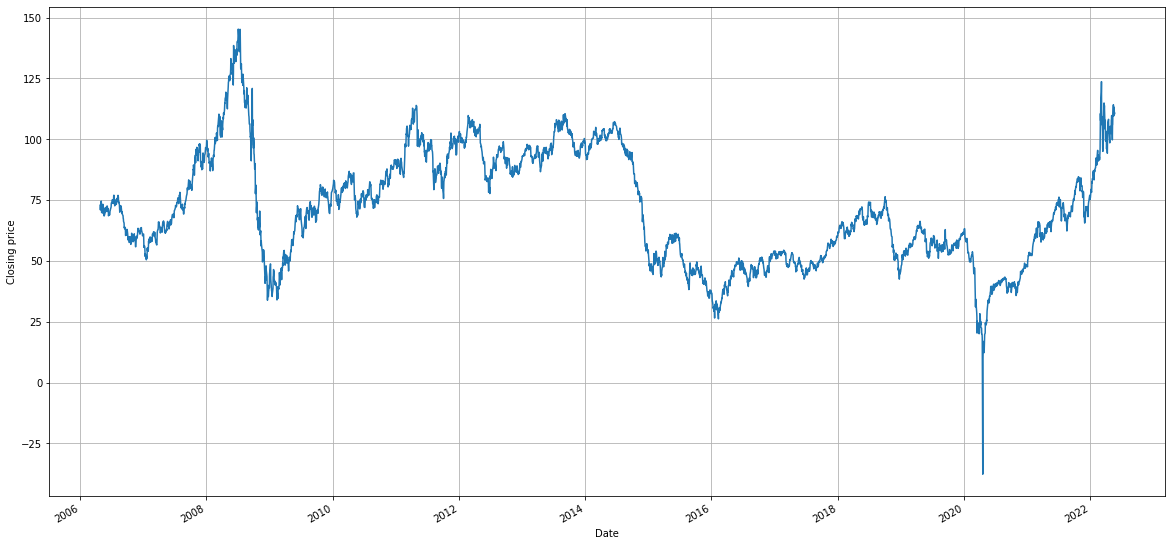

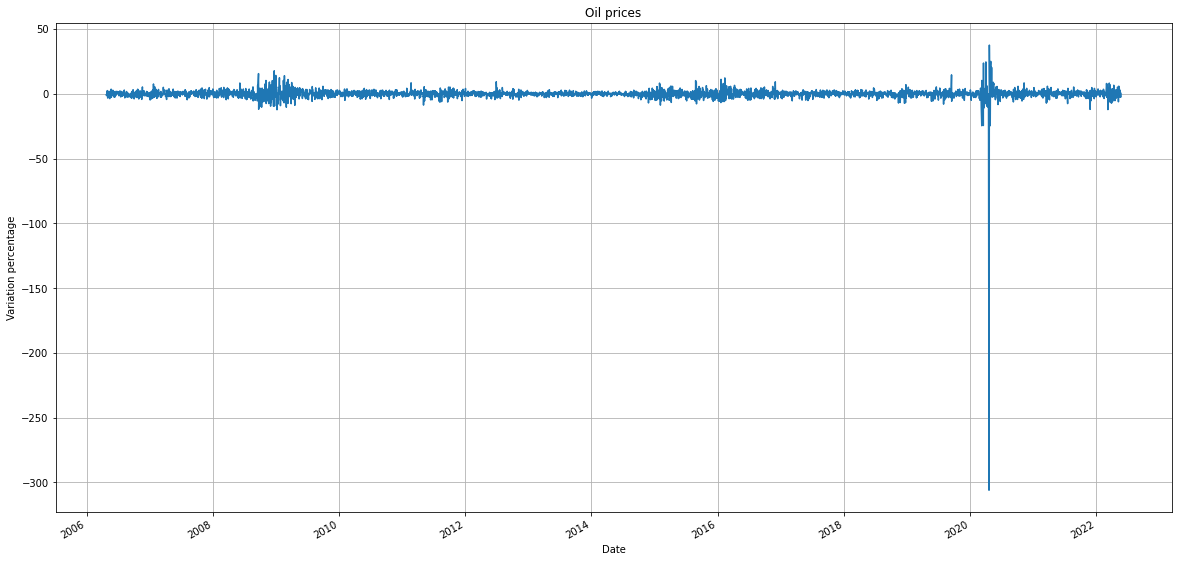

In [10]:
ax1 = df_petroleo.plot(use_index=True, y='Close', style=['-'], figsize=(20,10), ylabel='Closing price', legend=False, grid=True)
ax2 = df_petroleo.plot(use_index=True, y='Variation', style=['-'], figsize=(20, 10), ylabel='Variation percentage', legend=False, grid=True)

plt.title('Oil prices')

Here, we see that closing prices follow an increasing trend in most periods, which is however halted by sharp decreases. These occur, for example, in 2008, 2014 and 2020 (this last one possibly be due to the COVID-19 pandemic). Moreover the variation percentage seems to have remained mostly stable and close to zero (minus the sharp decrease in 2020). Some periods with more significant variations are 2009-2010 and 2015-2017.

A dotted plot would allow us to visualize better the previous variations in these graphs. 

<Figure size 432x288 with 0 Axes>

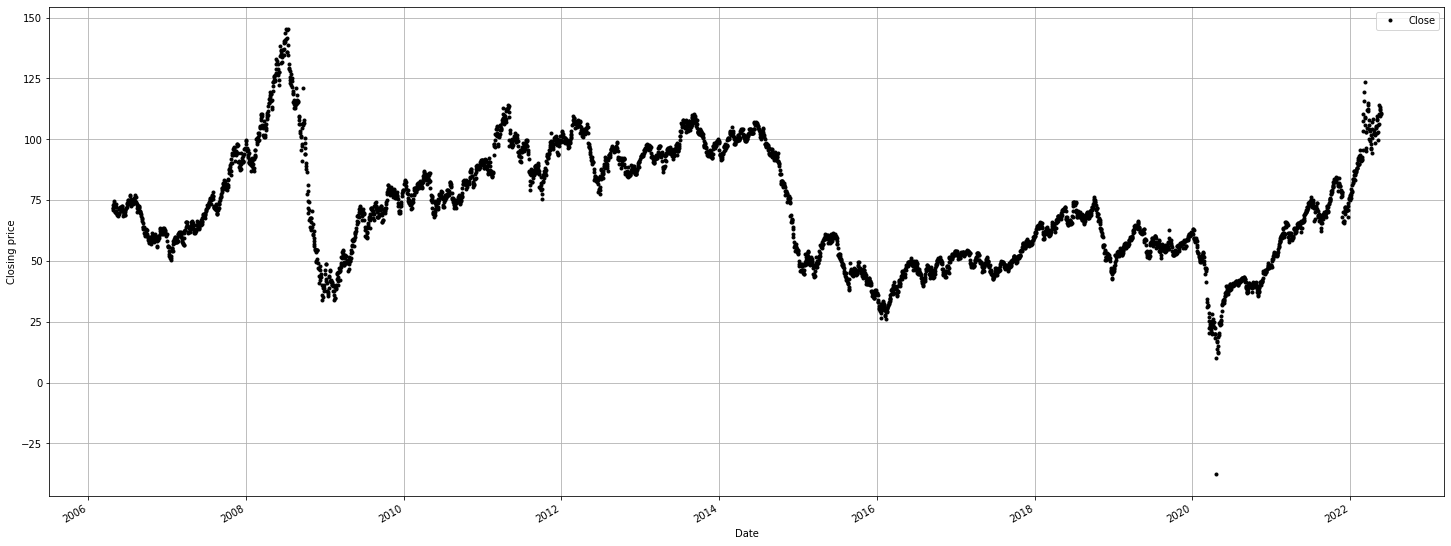

<Figure size 432x288 with 0 Axes>

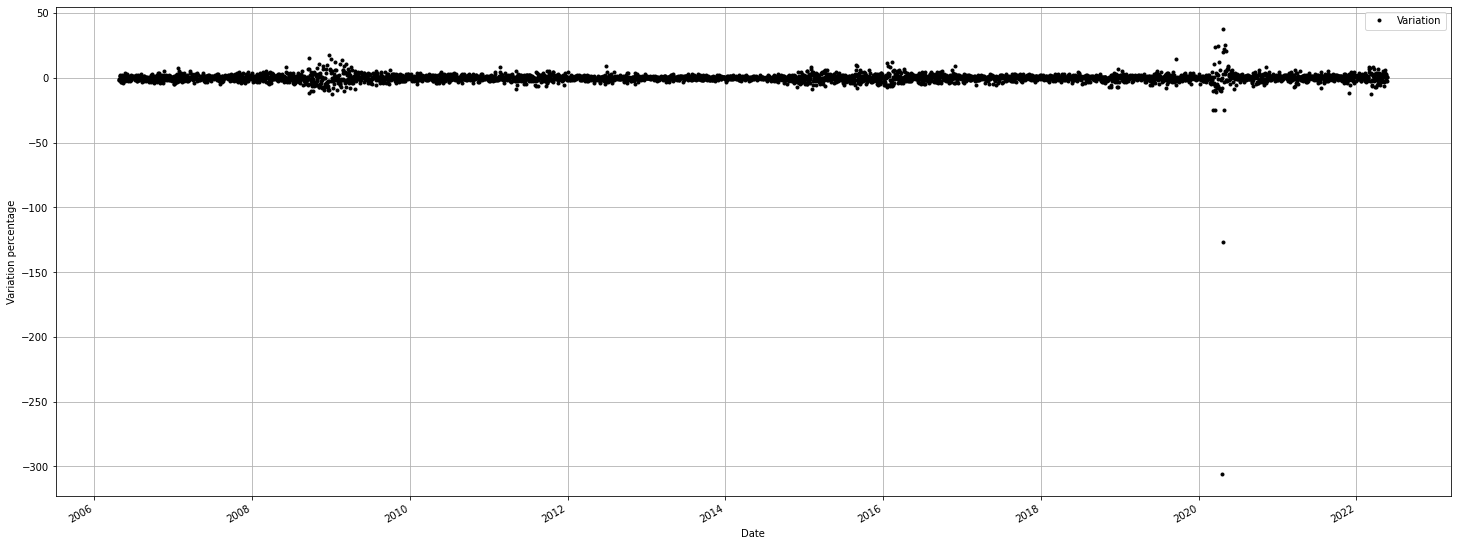

In [11]:
plt.figure()
ax3 = df_petroleo.plot(use_index=True, y='Close', style='k.', grid=True, figsize=(25,10), ylabel='Closing price')
plt.figure()
ax4 = df_petroleo.plot(use_index=True, y='Variation', style='k.', grid=True, figsize=(25,10), ylabel='Variation percentage')

Now, let us now examine the distributions of our variables via histograms:

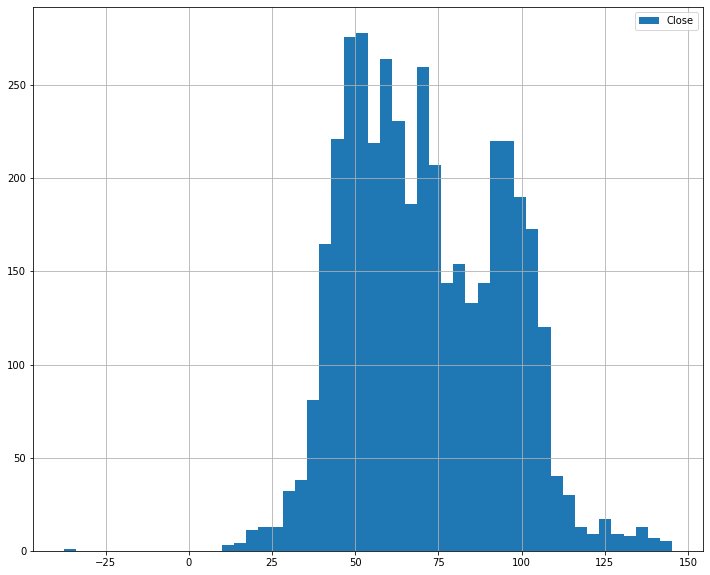

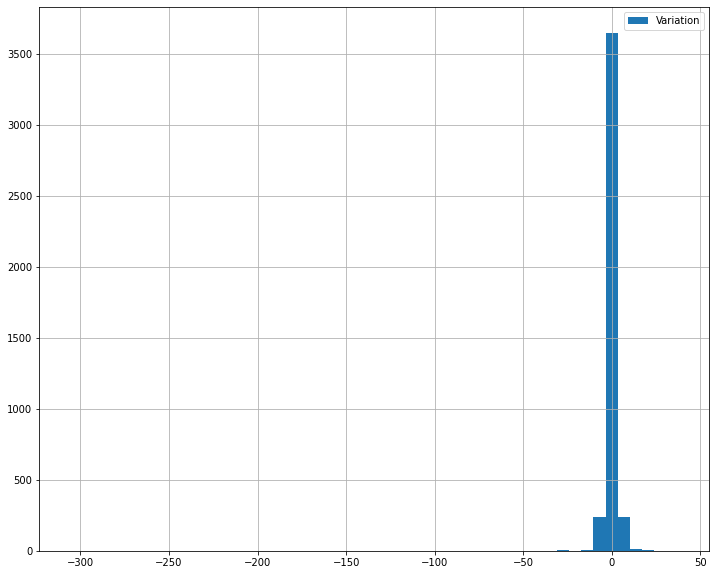

In [12]:
plt.figure()
ax5 = df_petroleo['Close'].hist(bins=50, figsize=(12,10), legend=True)

plt.figure()
ax6 = df_petroleo['Variation'].hist(bins=50, figsize=(12,10), legend=True)

The histogram for closing price shows that oil has been worth most often ~50 USD, and, in general, frequent values occur in the 50 USD - 100 USD range. This distribution does not seem to be skewed, nor absolutely symmetrical. In the case of variation percentage, the values are most often near zero, except for drastic outliers.

Density plots, as an alternative to histograms, yield similar results:

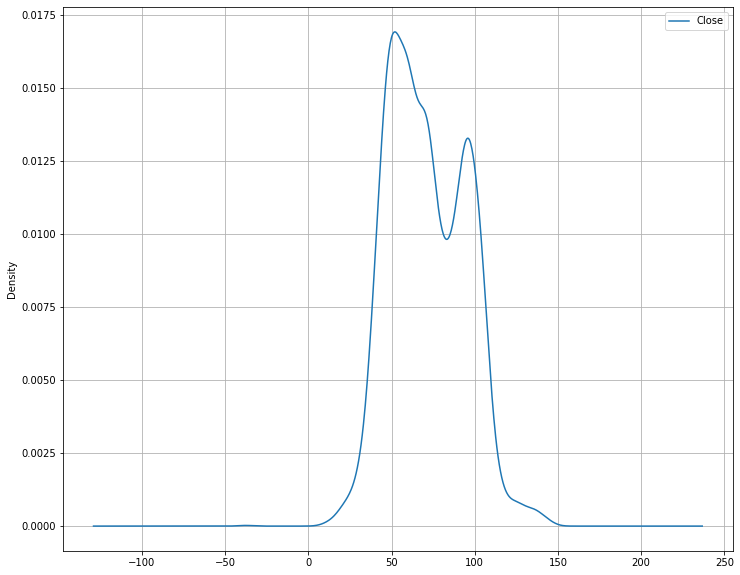

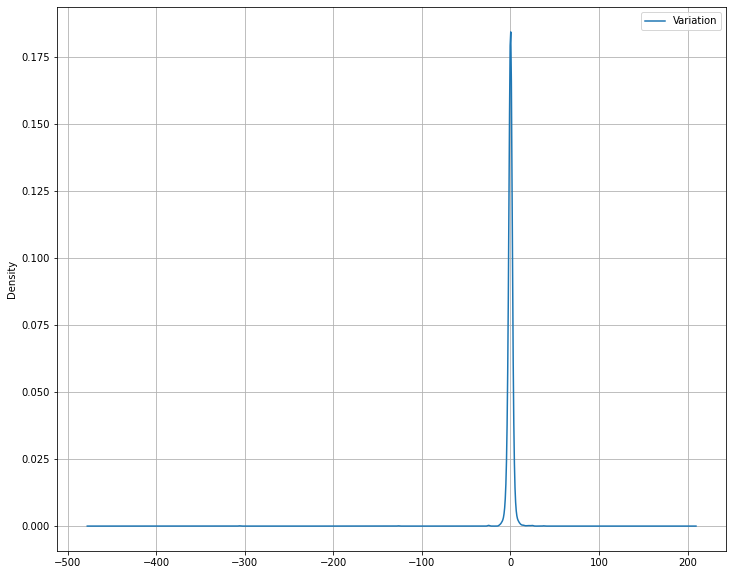

In [13]:
ax6 = df_petroleo['Close'].plot(kind='kde', figsize=(12,10), grid=True, legend=True)
plt.figure()
ax7 = df_petroleo['Variation'].plot(kind='kde', figsize=(12,10), grid=True, legend=True)

In order to reduce data variation, we showcase a moving average consisting of a window of 200 periods that presents the average evolution of the price based on the previous 200 data entries. This strategy does indeed reduce variations due to small peaks/valleys:

<AxesSubplot:xlabel='Date', ylabel='Closing price'>

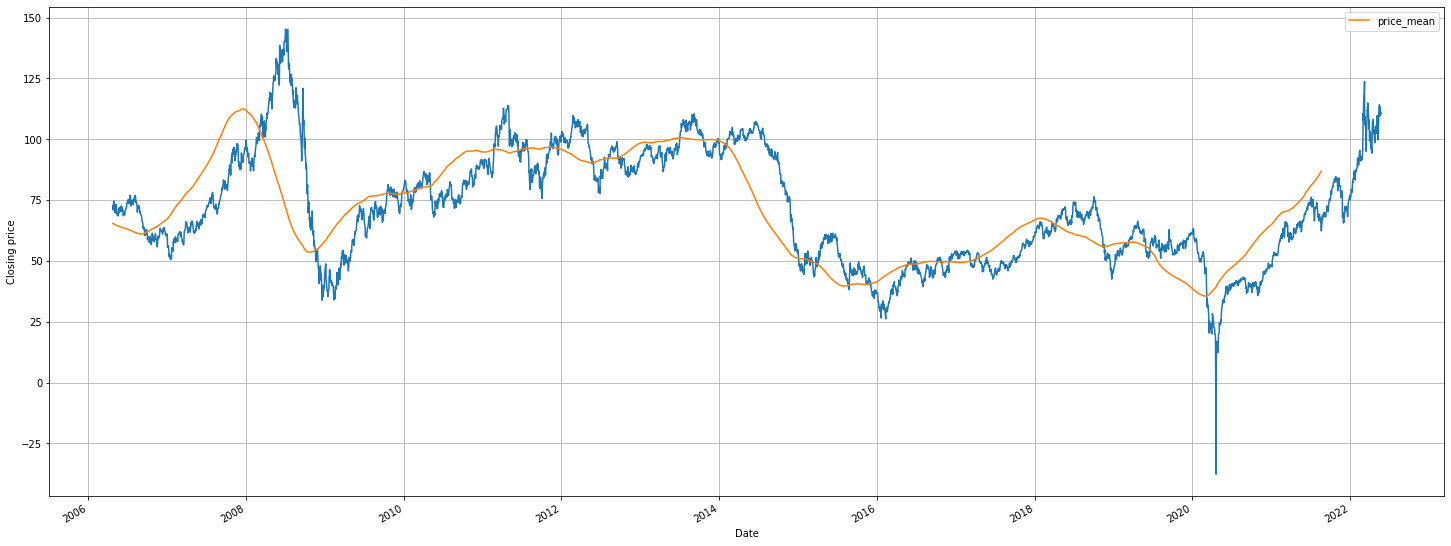

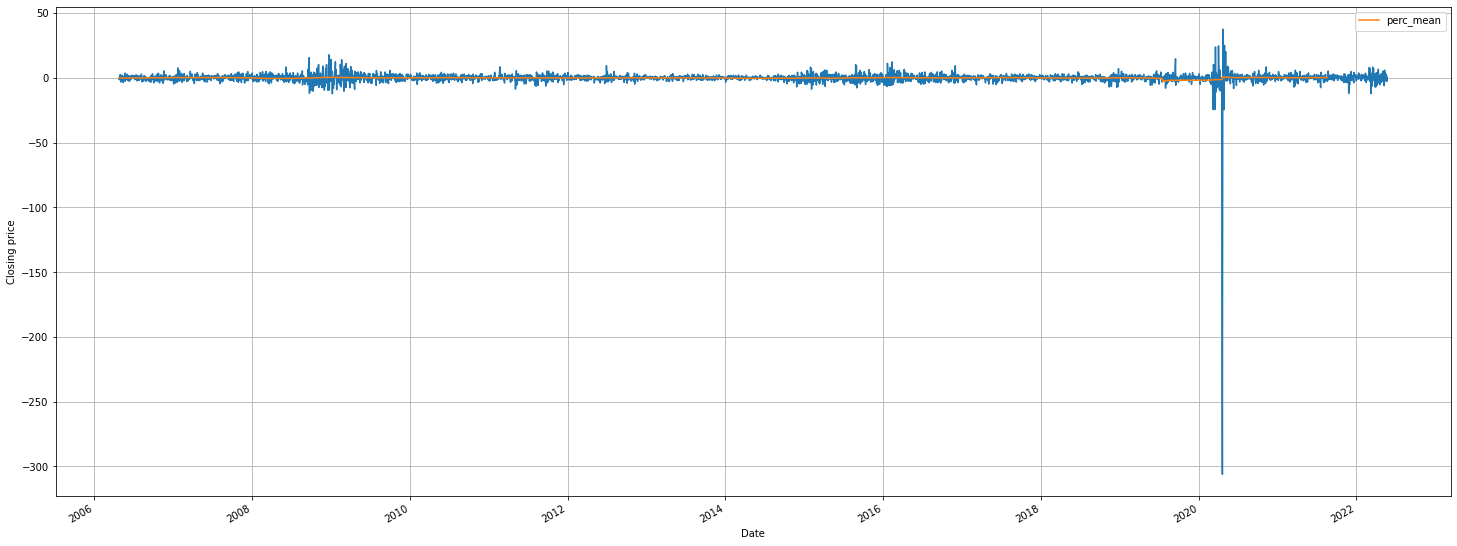

In [14]:
df_petroleo['price_mean'] = df_petroleo['Close'].rolling(200, win_type=None).mean()
ax11 = df_petroleo.plot(use_index=True, y='Close', style=['-'], figsize=(25,10), ylabel='Closing price', legend=False, grid=True)
df_petroleo.plot(y='price_mean', style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=ax11)

df_petroleo['perc_mean'] = df_petroleo['Variation'].rolling(200, win_type=None).mean()
ax22 = df_petroleo.plot(use_index=True, y='Variation', style=['-'], figsize=(25,10), ylabel='Variation percentage',
 legend=False, grid=True)
df_petroleo.plot(y='perc_mean', style=['-', '--', ':'], grid=True, ylabel='Closing price', ax=ax22)

Let us now reduce variation by smoothing the data. Exponential smoothing allows noise to be smoothed without time shift implications, and thus is preferred

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Date', ylabel='Closing price'>

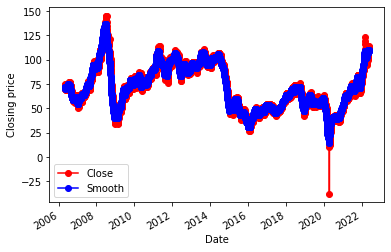

In [15]:
model = SimpleExpSmoothing(df_petroleo['Close']).fit(smoothing_level=.1, optimized=True)
df_petroleo['Smooth'] = model.fittedvalues
ax8 = df_petroleo.plot(y='Close', marker='o', color='red', ylabel='Closing price')
df_petroleo.plot(y='Smooth', marker='o', color='blue', ylabel='Closing price', ax=ax8)

A lag plot allows us to check for randomness. A lag plot with little data dispersion indicates that the data is not random, and instead follows a certain trend.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

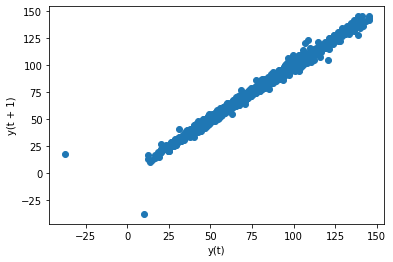

In [16]:
lag_plot(df_petroleo['Close'])

The absence of mainly random behavior can be verified via an autocorrelation plot. If the plot is distant from zero, then indeed randomness is not a main factor in this time series

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

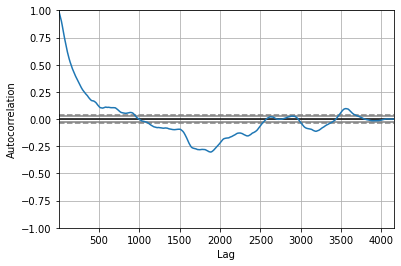

In [17]:
autocorrelation_plot(df_petroleo['Close'])

Now, let us inspect the distribution of the stock volume via a histogram:

<AxesSubplot:>

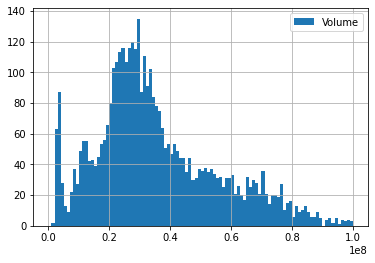

In [18]:
df_petroleo['Volume'].hist(bins=100, legend=True, range=(0,1e8))

The volume distribution seems to be skewed to the right. We can interpret this as it follows: there are fewer instances of our dataset in which a particularly high volume (near to 10^8) occurs (that is, most entries correspond to a medium-low amount of oil trades).

## Yearly price and volume trend

In [19]:
# Reverse chronological order
df_petroleo = df_petroleo.loc[::-1] 

<Figure size 432x288 with 0 Axes>

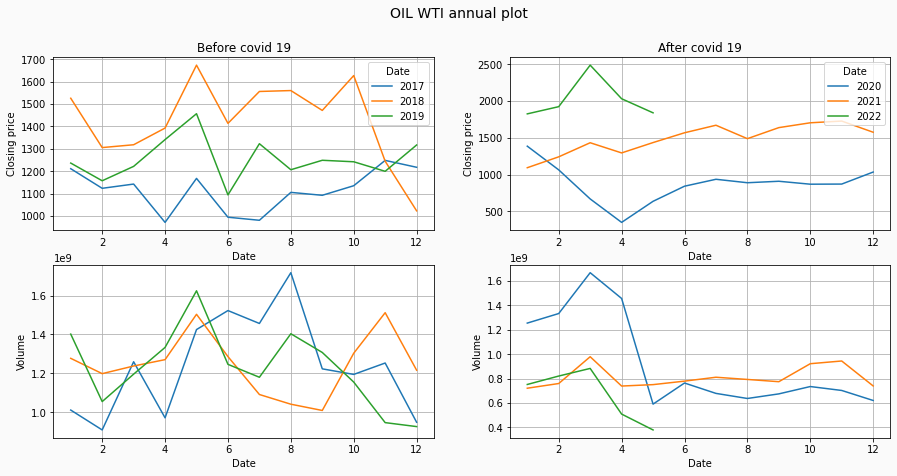

In [20]:
plt.figure()
fig1, axes1 = plt.subplots(nrows=2, ncols=2, figsize=(15, 7), facecolor=(.98, .98, .98))
fig1.suptitle('OIL WTI annual plot', fontsize=14)

df_aux = df_petroleo.loc['2017-01-01':'2019-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1[0,0])
ax1.set_title('Before covid 19')

df_aux = df_petroleo.loc['2020-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Close', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Closing price', grid=True, ax=axes1[0,1])
ax1.set_title('After covid 19')

df_aux = df_petroleo.loc['2017-01-01':'2019-12-31']
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Volume', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Volume', legend=False, grid=True, ax=axes1[1,0])

df_aux = df_petroleo.loc['2020-01-01':]
pv = pd.pivot_table(df_aux, index=df_aux.index.month, columns=df_aux.index.year, values='Volume', aggfunc='sum')
ax1 = pv.plot(use_index=True, style=['-'], ylabel='Volume', grid=True, legend=False, ax=axes1[1,1])

In [21]:
years = df_petroleo['Year'].unique()
vol_yearly = pd.DataFrame()
close_yearly = pd.DataFrame()
for y in years:
    df_aux = df_petroleo[df_petroleo['Year']==y].groupby('Month')[['Volume','Close']].mean()
    vol_yearly = pd.concat([vol_yearly, df_aux[['Volume']].T.set_index(pd.Index([y]))])
    close_yearly = pd.concat([close_yearly, df_aux[['Close']].T.set_index(pd.Index([y]))])

In [22]:
vol_yearly_mean = pd.DataFrame()
close_yearly_mean = pd.DataFrame()
for y in years:
    vol_yearly_mean[y] = vol_yearly.mean()
    close_yearly_mean[y] = close_yearly.mean()

<Figure size 432x288 with 0 Axes>

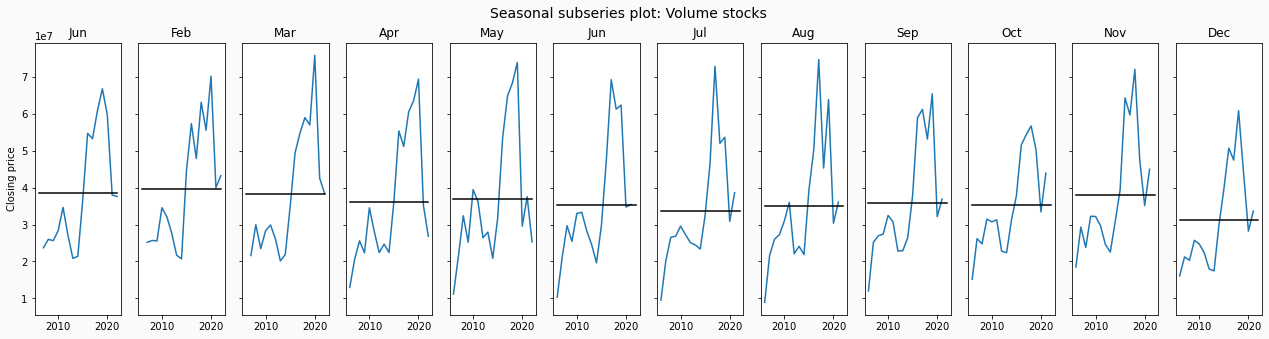

In [23]:
months = ['Jun', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.figure()
fig1, axes1 = plt.subplots(nrows=1, ncols=12, figsize=(22, 5), sharey=True, facecolor=(.98, .98, .98))
fig1.suptitle('Seasonal subseries plot: Volume stocks', fontsize=14)
for i in vol_yearly:
    vol_yearly[i].plot(grid=True, legend=False, title=months[i-1], ylabel='Closing price', ax = axes1[i-1]);
    vol_yearly_mean.T[i].plot(legend=False, ax = axes1[i-1], color ='k');